# Do interface design to further filter out unproductive designs prior to looping

In [1]:
# %load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers
running on node: sofia


In [2]:
os.chdir("/home/broerman/projects/crispy_shifty")
sys.path.insert(0, os.getcwd())

In [2]:
def create_tasks(selected, options):
    with open(selected, "r") as f:
        for line in f:
            tasks = {"options": "-corrections::beta_nov16 true"}
            tasks["extra_options"] = options
            tasks["pdb_path"] = line.rstrip()
            yield tasks

In [ ]:
os.chdir("/home/broerman/projects/crispy_shifty")
# Python standard library
import os
import pwd
import socket
import sys

# 3rd party library imports
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

# Rosetta library imports
from pyrosetta.distributed.cluster.core import PyRosettaCluster

# Custom library imports
sys.path.insert(0, os.getcwd())
from crispy_shifty.protocols.design import one_state_design_unlooped_dimer  # the functions we will distribute

print(f"View dashboard at http://{socket.gethostname()}:8787")

selected = os.path.join(os.getcwd(), "projects/crispy_shifty_dimers/01_make_states/states.list")

options = {
    "-out:level": "100",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
    "-precompute_ig": "true"
}

output_path = os.path.join(os.getcwd(), "projects/crispy_shifty_dimers/02_design_filter")
os.makedirs(output_path, exist_ok=True)

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="10GB",
        queue="backfill",
        walltime="11:30:00",
        death_timeout=120,
        local_directory="$TMPDIR",  # spill worker litter on local node temp storage
        log_directory=os.path.join(output_path, "slurm_logs"),
        extra=["--lifetime", "11h", "--lifetime-stagger", "5m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-300 workers,
        cluster.adapt(
            minimum=1,
            maximum=300,
            wait_count=999,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
            target_duration="60s",
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            client.upload_file(
                os.path.join(os.getcwd(), "crispy_shifty/protocols/design.py")
            )  # upload the script that contains the functions to distribute
            PyRosettaCluster(
                client=client,
                logging_level="ERROR",
                output_path=output_path,
                project_name="crispy_shifty_dimers",
                scratch_dir=output_path,
                simulation_name="02_design_filter",
                tasks=create_tasks(selected, options),
                nstruct=10,
            ).distribute(protocols=[one_state_design_unlooped_dimer])
            client.close()
        cluster.scale(0)
        cluster.close()
    print("distributed run complete")

View dashboard at http://dig62:8787
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=12G
#SBATCH -t 23:30:00

/projects/crispy_shifty/envs/crispy/bin/python -m distributed.cli.dask_worker tcp://172.16.131.92:34317 --nthreads 1 --memory-limit 11.18GiB --name dummy-name --nanny --death-timeout 120 --local-directory $TMPDIR --lifetime 23h --lifetime-stagger 5m --protocol tcp://

<Client: 'tcp://172.16.131.92:34317' processes=0 threads=0, memory=0 B>


KeyboardInterrupt: 

In [3]:
def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores

os.chdir("/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers")
output_path = os.path.join(os.getcwd(), "02_design_filter")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

,bb_clash,bb_clash_A,bb_clash_B,cms_ac_bn,cms_dhr,cms_dhr_ac,cms_dhr_bn,dhr_ac_int_count,dhr_bn_int_count,dhr_int_count,...,shift_A,shift_B,ss_sc,total_score,wnm_1,wnm_2,wnm_3,wnm_4,wnm_hlx,yhh_planarity
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_c6b1cf65d1314fa4a7efe90793d83846.pdb.bz2,110.83558654785156,56.11193084716797,54.72365951538086,-1.000000,368.517517,514.184814,637.900879,26.0,35.0,19.0,...,-6.0,6.0,0.713926,41261.58817176744,0.354899,0.397061,0.329438,0.365875,0.129802,0.0
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_1c00614344c540838651ab1189b900e9.pdb.bz2,4650.0625,41.235984802246094,41.235984802246094,-1.000000,245.856781,320.443359,0.000000,12.0,37.0,15.0,...,1.0,-1.0,0.733583,22383.564461821425,0.363062,0.459005,0.373733,0.435767,0.089698,0.0
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_d1ad7b79dddf4566bed7b5cfc3893bcd.pdb.bz2,4802.529296875,37.104209899902344,613.51220703125,-1.000000,152.555206,324.429718,314.094727,15.0,31.0,14.0,...,5.0,3.0,0.720846,30201.420730267128,0.281702,0.284034,0.373289,0.349887,0.115567,0.0015607019201311911
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_6fbd5efe0f2d418eaaede06ebfcafd49.pdb.bz2,103.79744720458984,69.95219421386719,33.758880615234375,0.121686,322.327301,384.285004,297.629730,20.0,10.0,5.0,...,5.0,-1.0,0.725128,20943.983241058155,0.256686,0.225569,0.257751,0.200958,0.108887,0.0
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_26cfe49f56cd433b853590bf0036a35b.pdb.bz2,2832.929931640625,37.104209899902344,2794.31787109375,-1.000000,128.971451,296.732544,126.221008,15.0,24.0,14.0,...,5.0,2.0,0.703402,22138.093955425633,0.286762,0.299825,0.254358,0.303265,0.104817,0.0015607019201311911


In [4]:
print(scores_df.columns)
print(len(scores_df))

Index(['bb_clash', 'bb_clash_A', 'bb_clash_B', 'cms_ac_bn', 'cms_dhr',
       'cms_dhr_ac', 'cms_dhr_bn', 'dhr_ac_int_count', 'dhr_bn_int_count',
       'dhr_int_count', 'dslf_fa13', 'fa_atr', 'fa_dun', 'fa_elec',
       'fa_intra_rep', 'fa_intra_sol_xover4', 'fa_rep', 'fa_sol',
       'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'lk_ball_wtd',
       'loop_dist_A', 'loop_dist_B', 'omega', 'p_aa_pp', 'parent',
       'parent_length', 'parent_loop_dist', 'parent_path', 'pivot_helix_A',
       'pivot_helix_B', 'pre_break_helix', 'pro_close', 'rama_prepro', 'ref',
       'sc_ac_bn', 'sc_dhr', 'sc_dhr_ac', 'sc_dhr_bn', 'score', 'score_1',
       'score_124', 'score_134', 'score_14', 'score_2', 'score_23', 'score_3',
       'score_4', 'score_per_res', 'shift_A', 'shift_B', 'ss_sc',
       'total_score', 'wnm_1', 'wnm_2', 'wnm_3', 'wnm_4', 'wnm_hlx',
       'yhh_planarity'],
      dtype='object')
12993


In [5]:
# Add the input path to the dataframe
import pyrosetta.distributed.cluster as cluster
for index, row in tqdm(scores_df.iterrows()):
    input_path = cluster.get_scores_dict(index)['instance']['tasks']['pdb_path']
    scores_df.at[index, 'input_path'] = input_path

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
12993it [03:09, 68.72it/s]


In [6]:
scores_df['input_path'].nunique()

2557

100%|██████████| 12993/12993 [00:00<00:00, 1515941.80it/s]


<AxesSubplot:ylabel='Count'>

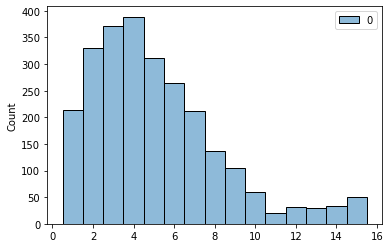

In [7]:
input_path_dict = {}
for input_path in tqdm(scores_df['input_path']):
    if input_path in input_path_dict:
        input_path_dict[input_path] += 1
    else:
        input_path_dict[input_path] = 1

sns.histplot(input_path_dict.values(), discrete=True)

In [8]:
scores_df['parent'].nunique()

213

In [9]:
# Compute derivative scores, then check whether there is significant variation among scores for designs from the same input

scores_df['de_1_4'] = scores_df['score_14'] - scores_df['score_1'] - scores_df['score_4']
scores_df['de_14_2'] = scores_df['score_124'] - scores_df['score_14'] - scores_df['score_2']
scores_df['de_14_3'] = scores_df['score_134'] - scores_df['score_14'] - scores_df['score_3']
scores_df['de_2_3'] = scores_df['score_23'] - scores_df['score_2'] - scores_df['score_3']
scores_df['wnm'] = scores_df[['wnm_1', 'wnm_2', 'wnm_3', 'wnm_4']].max(axis=1)
scores_df['delta_loop_dist_A'] = scores_df['loop_dist_A'].astype(float) - scores_df['parent_loop_dist'].astype(float)
scores_df['delta_loop_dist_B'] = scores_df['loop_dist_B'].astype(float) - scores_df['parent_loop_dist'].astype(float)

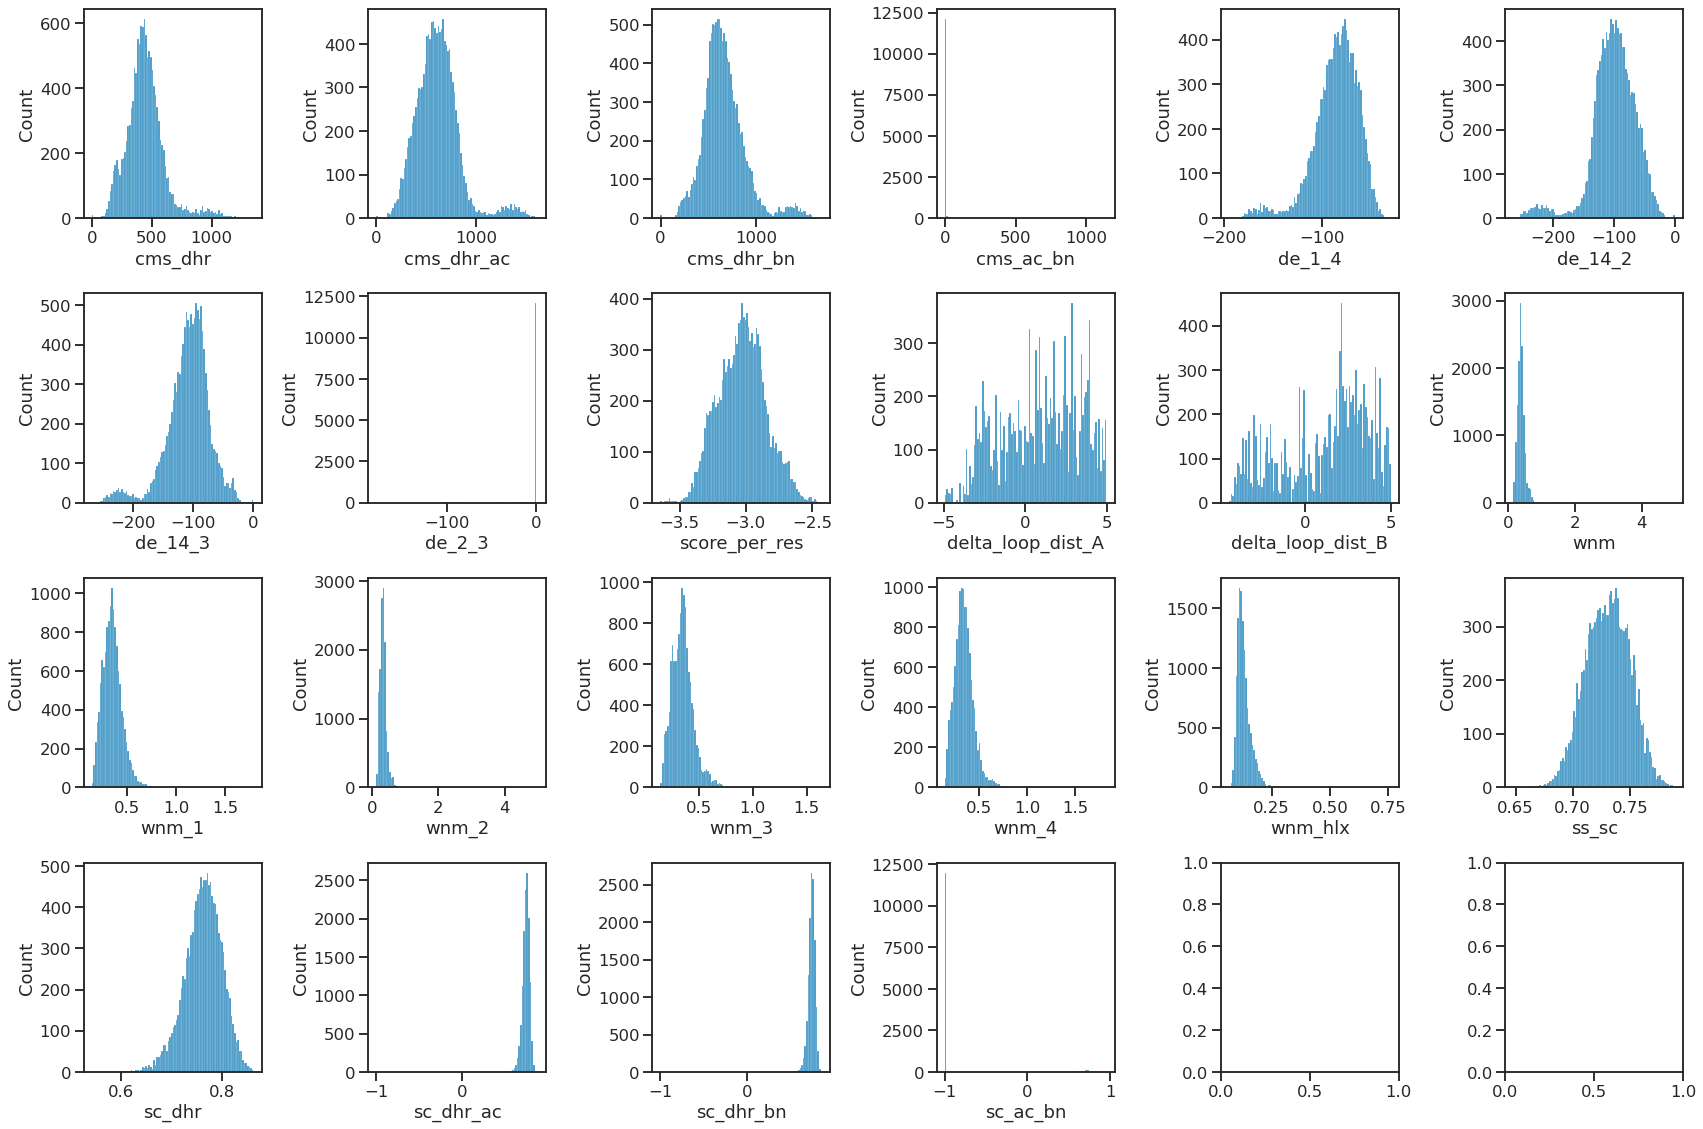

In [10]:
from crispy_shifty.plotting.utils import histplot_df

cols = [
        "cms_dhr",
        "cms_dhr_ac",
        "cms_dhr_bn",
        "cms_ac_bn",
        "de_1_4",
        "de_14_2",
        "de_14_3",
        "de_2_3",
        "score_per_res",
        "delta_loop_dist_A",
        "delta_loop_dist_B",
        "wnm",
        "wnm_1",
        "wnm_2",
        "wnm_3",
        "wnm_4",
        "wnm_hlx",
        "ss_sc",
        "sc_dhr",
        "sc_dhr_ac",
        "sc_dhr_bn",
        "sc_ac_bn"
    #     "parent",
    ]

histplot_df(scores_df, cols=cols, bins=100)

51


51it [00:10,  4.68it/s]


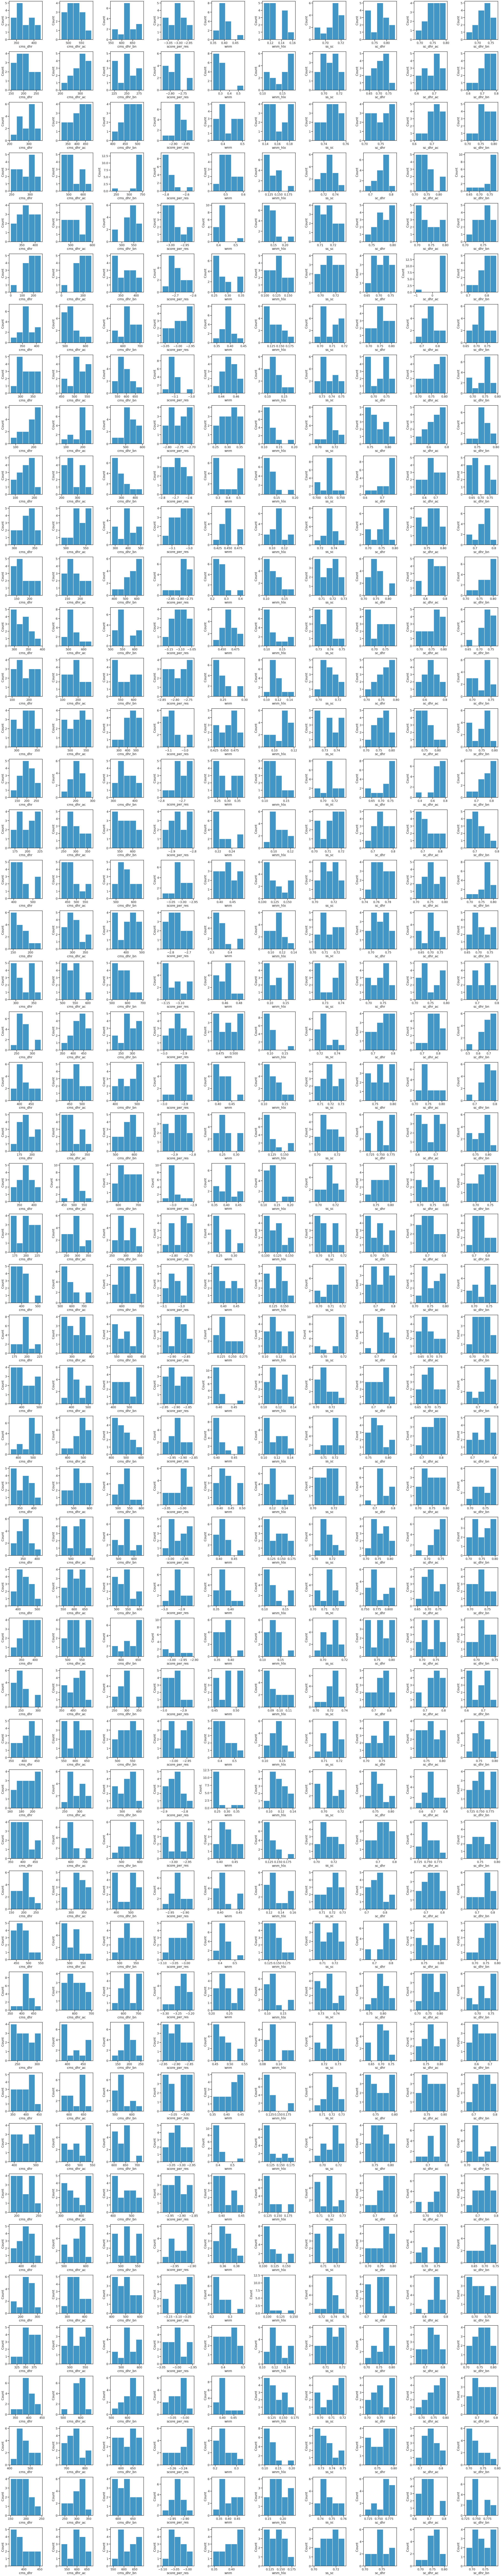

In [19]:
# Look at the distributions of scores for each input- see if there is significant variation, indicating I need to sample more, or if I
# only need to sample a few design trajectories for each design.
# Let's look at the ~50 inputs for which I sampled 15 trajectories, so I have some more data.

input_paths_15 = []
for input_path, num_occurrences in input_path_dict.items():
    if num_occurrences == 15:
        input_paths_15.append(input_path)
num_input_15 = len(input_paths_15)
print(num_input_15)

inputs_cols = [
        "cms_dhr",
        "cms_dhr_ac",
        "cms_dhr_bn",
        "score_per_res",
        "wnm",
        "wnm_hlx",
        "ss_sc",
        "sc_dhr",
        "sc_dhr_ac",
        "sc_dhr_bn",
    ]
num_cols = len(inputs_cols)

fig, axs = plt.subplots(num_input_15, num_cols, figsize=(4*num_cols, 4*num_input_15))

std_mean_df = pd.DataFrame(index=input_paths_15, columns=inputs_cols)

for i, input_path in tqdm(enumerate(input_paths_15)):
    scores_df_input = scores_df[scores_df['input_path'] == input_path]
    
    for j, col in enumerate(inputs_cols):
        sns.histplot(data=scores_df_input, x=col, ax=axs[i,j], bins=5)
    
    std_mean_df.loc[input_path, :] = scores_df_input[inputs_cols].std(axis=0) / scores_df_input[inputs_cols].mean(axis=0)

fig.tight_layout()

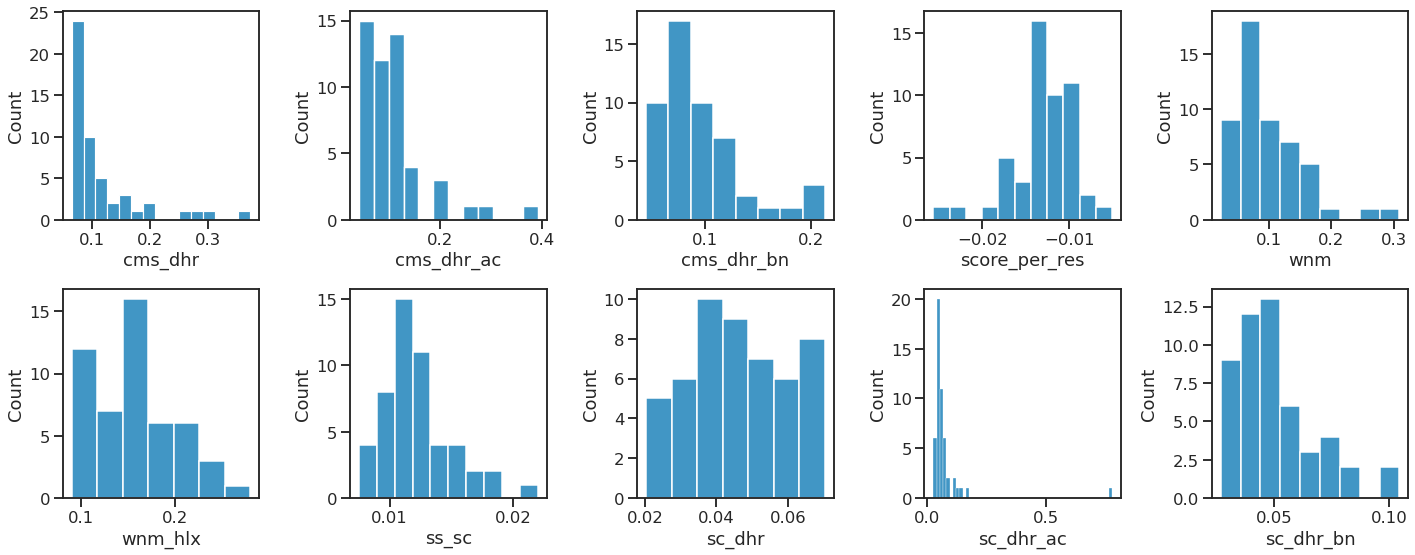

In [21]:
# Plots distributions of the standard deviations of the scores normalized by the mean of those scores for each input.
# For each metric, values around ~0.05 for sc, 0.1 for cms indicate I need to sample highly per design, maybe ~10 trajectories, to make
# full use of each design for optimizing that metric.

histplot_df(std_mean_df, cols=inputs_cols)

In [24]:
# This means I need to sample more for the inputs which only had a few or no corresponding designs. Generate a list of inputs with less than 5 designs
# and sample with nstruct 5.

input_scores_df = read_scorefile("/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/01_make_states/scores.json")

# get the paths to the inputs for which I have no designs
input_paths_to_sample = []
for input_path in input_scores_df.index:
    if input_path not in input_path_dict.keys():
        input_paths_to_sample.append(input_path)
print(len(input_paths_to_sample))

# get the paths to the inputs for which I have less than 5 designs
for input_path, num_occurrences in input_path_dict.items():
    if num_occurrences < 5:
        input_paths_to_sample.append(input_path)
print(len(input_paths_to_sample))

with open("/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/to_sample.list", 'w') as f:
    f.write('\n'.join(input_paths_to_sample))

75
1381


In [30]:
# Also need to generate a list of designs for which I haven't updated loop distances. This is everything in scores.json for 02_design_filter.
with open("/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/to_update_loop_dist.list", 'w') as f:
    f.write('\n'.join(scores_df.index))

In [5]:
os.chdir("/home/broerman/projects/crispy_shifty")
# Python standard library
import os
import pwd
import socket
import sys

# 3rd party library imports
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

# Rosetta library imports
from pyrosetta.distributed.cluster.core import PyRosettaCluster

# Custom library imports
from pyrosetta.distributed import requires_init
from typing import *
from pyrosetta.distributed.packed_pose.core import PackedPose
sys.path.insert(0, os.getcwd())
# wrap a function to distribute
@requires_init
def score_loop_dist_wrapper(
    packed_pose_in: Optional[PackedPose] = None, **kwargs
) -> Generator[PackedPose, PackedPose, None]:
    import pyrosetta
    import pyrosetta.distributed.io as io
    from crispy_shifty.protocols.cleaning import path_to_pose_or_ppose
    from crispy_shifty.protocols.design import score_loop_dist

    # generate poses or convert input packed pose into pose
    if packed_pose_in is not None:
        poses = [io.to_pose(packed_pose_in)]
        pdb_path = "none"
    else:
        pdb_path = kwargs["pdb_path"]
        poses = path_to_pose_or_ppose(
            path=pdb_path, cluster_scores=True, pack_result=False
        )

    for pose in poses:
        print("Scoring loop distance...", end="")
        pre_break_helix = int(float(pose.scores["pre_break_helix"]))
        score_loop_dist(pose, pre_break_helix, name="loop_dist_A")
        score_loop_dist(pose, 3*pre_break_helix, name="loop_dist_B")
        print("complete.")

        ppose = io.to_packed(pose)
        yield ppose

print(f"View dashboard at http://{socket.gethostname()}:8787")

selected = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/to_update_loop_dist.list"

options = {
    "-out:level": "100",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
    "-precompute_ig": "true"
}

output_path = os.path.join(os.getcwd(), "projects/crispy_shifty_dimers/02_design_filter_2")
os.makedirs(output_path, exist_ok=True)

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="3GB",
        queue="short",
        walltime="2:30:00",
        death_timeout=120,
        local_directory="$TMPDIR",  # spill worker litter on local node temp storage
        log_directory=os.path.join(output_path, "slurm_logs"),
        extra=["--lifetime", "3h", "--lifetime-stagger", "5m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-100 workers,
        cluster.adapt(
            minimum=1,
            maximum=100,
            wait_count=999,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
            target_duration="60s",
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            PyRosettaCluster(
                client=client,
                logging_level="ERROR",
                output_path=output_path,
                project_name="crispy_shifty_dimers",
                scratch_dir=output_path,
                simulation_name="02_design_filter",
                tasks=create_tasks(selected, options),
                nstruct=1,
            ).distribute(protocols=[score_loop_dist_wrapper])
            client.close()
        cluster.scale(0)
        cluster.close()
    print("distributed run complete")

View dashboard at http://dig107:8787
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/slurm_logs/dask-worker-%J.out
#SBATCH -p short
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=3G
#SBATCH -t 2:30:00

/projects/crispy_shifty/envs/crispy/bin/python -m distributed.cli.dask_worker tcp://172.16.131.211:44421 --nthreads 1 --memory-limit 2.79GiB --name dummy-name --nanny --death-timeout 120 --local-directory $TMPDIR --lifetime 3h --lifetime-stagger 5m --protocol tcp://

<Client: 'tcp://172.16.131.211:44421' processes=0 threads=0, memory=0 B>


`conda env export --prefix /projects/crispy_shifty/envs/crispy > environment.yml`
to reproduce this simulation later.
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7ff8f9a387c0>>, <Task finished name='Task-1334697' coro=<Cluster._sync_cluster_info() done, defined at /projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/distributed/deploy/cluster.py:104> exception=CommClosedError("Exception while trying to call remote method 'set_metadata' before comm was established.")>)
Traceback (most recent call last):
  File "/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/distributed/comm/tcp.py", line 205, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/projects/crispy_shifty/env

distributed run complete


In [ ]:
# Finish sampling 

os.chdir("/home/broerman/projects/crispy_shifty")

# PyRosettaCluster needs to initialize an empty pose object if the job failed. This will fail if pyrosetta is not initialized, stopping the whole run.
pyrosetta.distributed.maybe_init(**{
    "options": "-corrections::beta_nov16 true",
    "extra_options":{
        "-out:level": "300",
        "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
        "-indexed_structure_store:fragment_store": "/home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",
        "-precompute_ig": "true",
        "-run:constant_seed": "1"
}})

# Python standard library
import os
import pwd
import socket
import sys

# 3rd party library imports
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

# Rosetta library imports
from pyrosetta.distributed.cluster.core import PyRosettaCluster

# Custom library imports
sys.path.insert(0, os.getcwd())
from crispy_shifty.protocols.design import one_state_design_unlooped_dimer  # the functions we will distribute

print(f"View dashboard at http://{socket.gethostname()}:8787")

selected = os.path.join(os.getcwd(), "projects/crispy_shifty_dimers/02_design_filter/to_sample.list")

options = {
    "-out:level": "100",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
    "-precompute_ig": "true"
}

output_path = os.path.join(os.getcwd(), "projects/crispy_shifty_dimers/02_design_filter_2")
os.makedirs(output_path, exist_ok=True)

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="10GB",
        queue="medium",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR",  # spill worker litter on local node temp storage
        log_directory=os.path.join(output_path, "slurm_logs"),
        extra=["--lifetime", "23h", "--lifetime-stagger", "5m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-1000 workers,
        cluster.adapt(
            minimum=1,
            maximum=1000,
            wait_count=999,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
            target_duration="60s",
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            client.upload_file(
                os.path.join(os.getcwd(), "crispy_shifty/protocols/design.py")
            )  # upload the script that contains the functions to distribute
            PyRosettaCluster(
                client=client,
                logging_level="ERROR",
                output_path=output_path,
                project_name="crispy_shifty_dimers",
                scratch_dir=output_path,
                simulation_name="02_design_filter",
                tasks=create_tasks(selected, options),
                nstruct=5,
                ignore_errors=True # for large runs so that the head process doesn't die due to a rare segfault in one of its children
            ).distribute(protocols=[one_state_design_unlooped_dimer])
            client.close()
        cluster.scale(0)
        cluster.close()
    print("distributed run complete")

View dashboard at http://dig147:8787
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_2/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=10G
#SBATCH -t 23:30:00

/projects/crispy_shifty/envs/crispy/bin/python -m distributed.cli.dask_worker tcp://172.16.131.31:41627 --nthreads 1 --memory-limit 9.31GiB --name dummy-name --nanny --death-timeout 120 --local-directory $TMPDIR --lifetime 23h --lifetime-stagger 5m --protocol tcp://

<Client: 'tcp://172.16.131.31:41627' processes=0 threads=0, memory=0 B>


`conda env export --prefix /projects/crispy_shifty/envs/crispy > environment.yml`
to reproduce this simulation later.


core.conformation.Conformation: [ WARNING ] Attempted to determine the residue type set of an empty pose.
core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 983 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 1.77606 seconds.


In [4]:
from crispy_shifty.utils.io import gen_array_tasks

design_list_file = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/to_sample.list"
output_path = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_3"

# Format as a string of key value pairs with no leading dashes on the argument names
options = "out:level 100 holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc indexed_structure_store:fragment_store /home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5 precompute_ig true"

gen_array_tasks(distribute_func='crispy_shifty.protocols.design.one_state_design_unlooped_dimer',
                design_list_file=design_list_file,
                output_path=output_path,
                queue='medium',
                memory='10G',
                nstruct=5,
                options=options,
                simulation_name='02_design_filter')

# gen_array_tasks('protocols.design.one_state_design_unlooped_dimer',
#                 design_list_file,
#                 output_path,
#                 'medium')

Run the following command with your desired environment active:
sbatch -a 1-$(cat /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_3/tasks.cmds | wc -l) /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter_3/run.sh


In [ ]:
# Now that I've sufficiently sampled most of the inputs, read the new final scorefile and filter

def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores

os.chdir("/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers")
output_path = os.path.join(os.getcwd(), "02_design_filter_2")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

In [ ]:
# Compute derivative scores

scores_df['de_1_4'] = scores_df['score_14'] - scores_df['score_1'] - scores_df['score_4']
scores_df['de_14_2'] = scores_df['score_124'] - scores_df['score_14'] - scores_df['score_2']
scores_df['de_14_3'] = scores_df['score_134'] - scores_df['score_14'] - scores_df['score_3']
scores_df['de_2_3'] = scores_df['score_23'] - scores_df['score_2'] - scores_df['score_3']
scores_df['wnm'] = scores_df[['wnm_1', 'wnm_2', 'wnm_3', 'wnm_4']].max(axis=1)
scores_df['delta_loop_dist_A'] = scores_df['loop_dist_A'].astype(float) - scores_df['parent_loop_dist'].astype(float)
scores_df['delta_loop_dist_B'] = scores_df['loop_dist_B'].astype(float) - scores_df['parent_loop_dist'].astype(float)

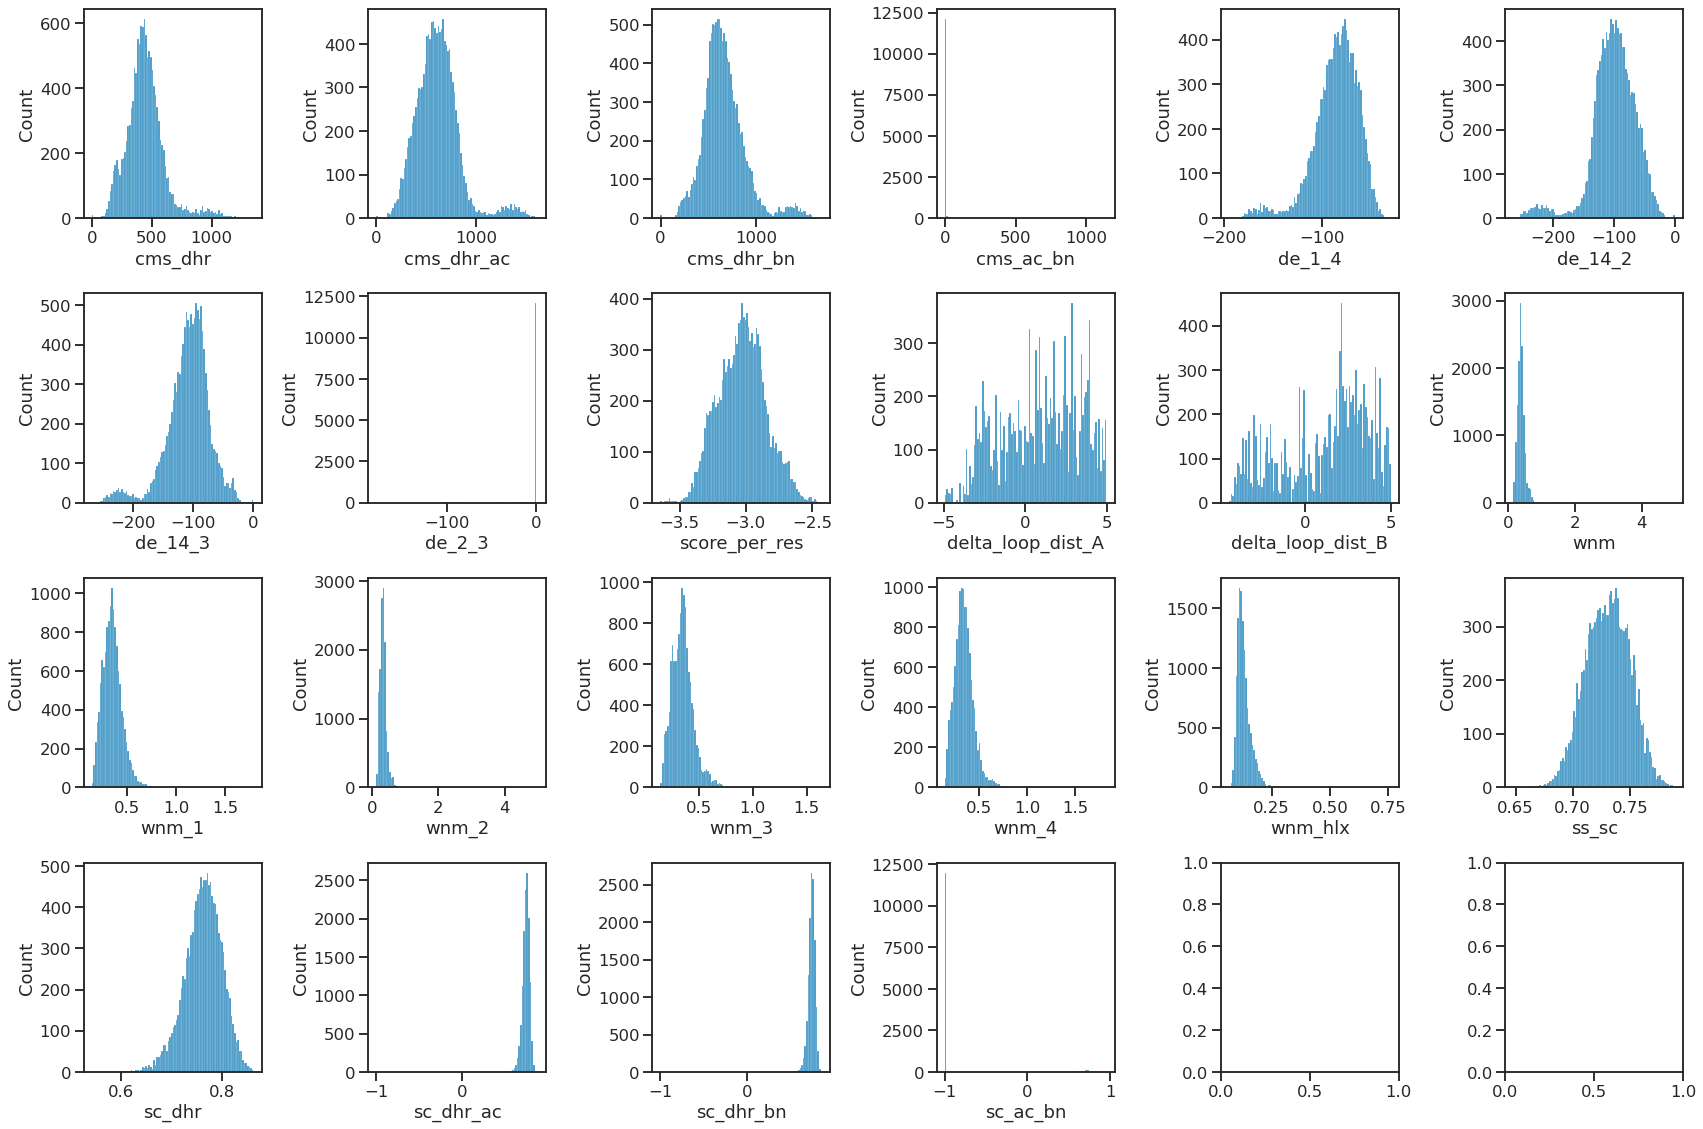

In [ ]:
from crispy_shifty.plotting.utils import histplot_df

cols = [
        "cms_dhr",
        "cms_dhr_ac",
        "cms_dhr_bn",
        "cms_ac_bn",
        "de_1_4",
        "de_14_2",
        "de_14_3",
        "de_2_3",
        "score_per_res",
        "delta_loop_dist_A",
        "delta_loop_dist_B",
        "wnm",
        "wnm_1",
        "wnm_2",
        "wnm_3",
        "wnm_4",
        "wnm_hlx",
        "ss_sc",
        "sc_dhr",
        "sc_dhr_ac",
        "sc_dhr_bn",
        "sc_ac_bn"
    #     "parent",
    ]

histplot_df(scores_df, cols=cols, bins=100)

In [ ]:
def filter_df(df, cutoffs):
    filtered_df = df

    for score_term, cutoff, greaterthan in cutoffs:
        if greaterthan:
            filtered_df = filtered_df[filtered_df[score_term] > cutoff]
        else:
            filtered_df = filtered_df[filtered_df[score_term] < cutoff]

    print(len(filtered_df))
    
    return filtered_df

def filter_df_delta(df, parent_df, delta_cutoffs):
    filtered_df = df

    for score_term, parent_term, cutoff, greaterthan in delta_cutoffs:
        filtered_series = filtered_df[score_term]
        parent_scores = parent_df.loc[filtered_df['parent'], parent_term]
        parent_scores.index = filtered_series.index
        # print(filtered_series)
        # print(parent_scores)
        # print(parent_scores - filtered_series < cutoff)
        if greaterthan:
            filtered_df = filtered_df[filtered_series - parent_scores > -cutoff]
        else:
            filtered_df = filtered_df[filtered_series - parent_scores < cutoff]
    
    print(len(filtered_df))
    
    return filtered_df

In [ ]:
# Filter designs- remove worst by worst9mer and whether the designs are exploded

cutoffs = [('cms_dhr', 1, 1),
           ('cms_dhr_ac', 1, 1),
           ('cms_dhr_bn', 1, 1),
           ('wnm', 0.4, 0),
           ('wnm_hlx', 0.15, 0)
]

filtered_df = filter_df(scores_df, cutoffs)

6120


22it [00:01, 13.45it/s]


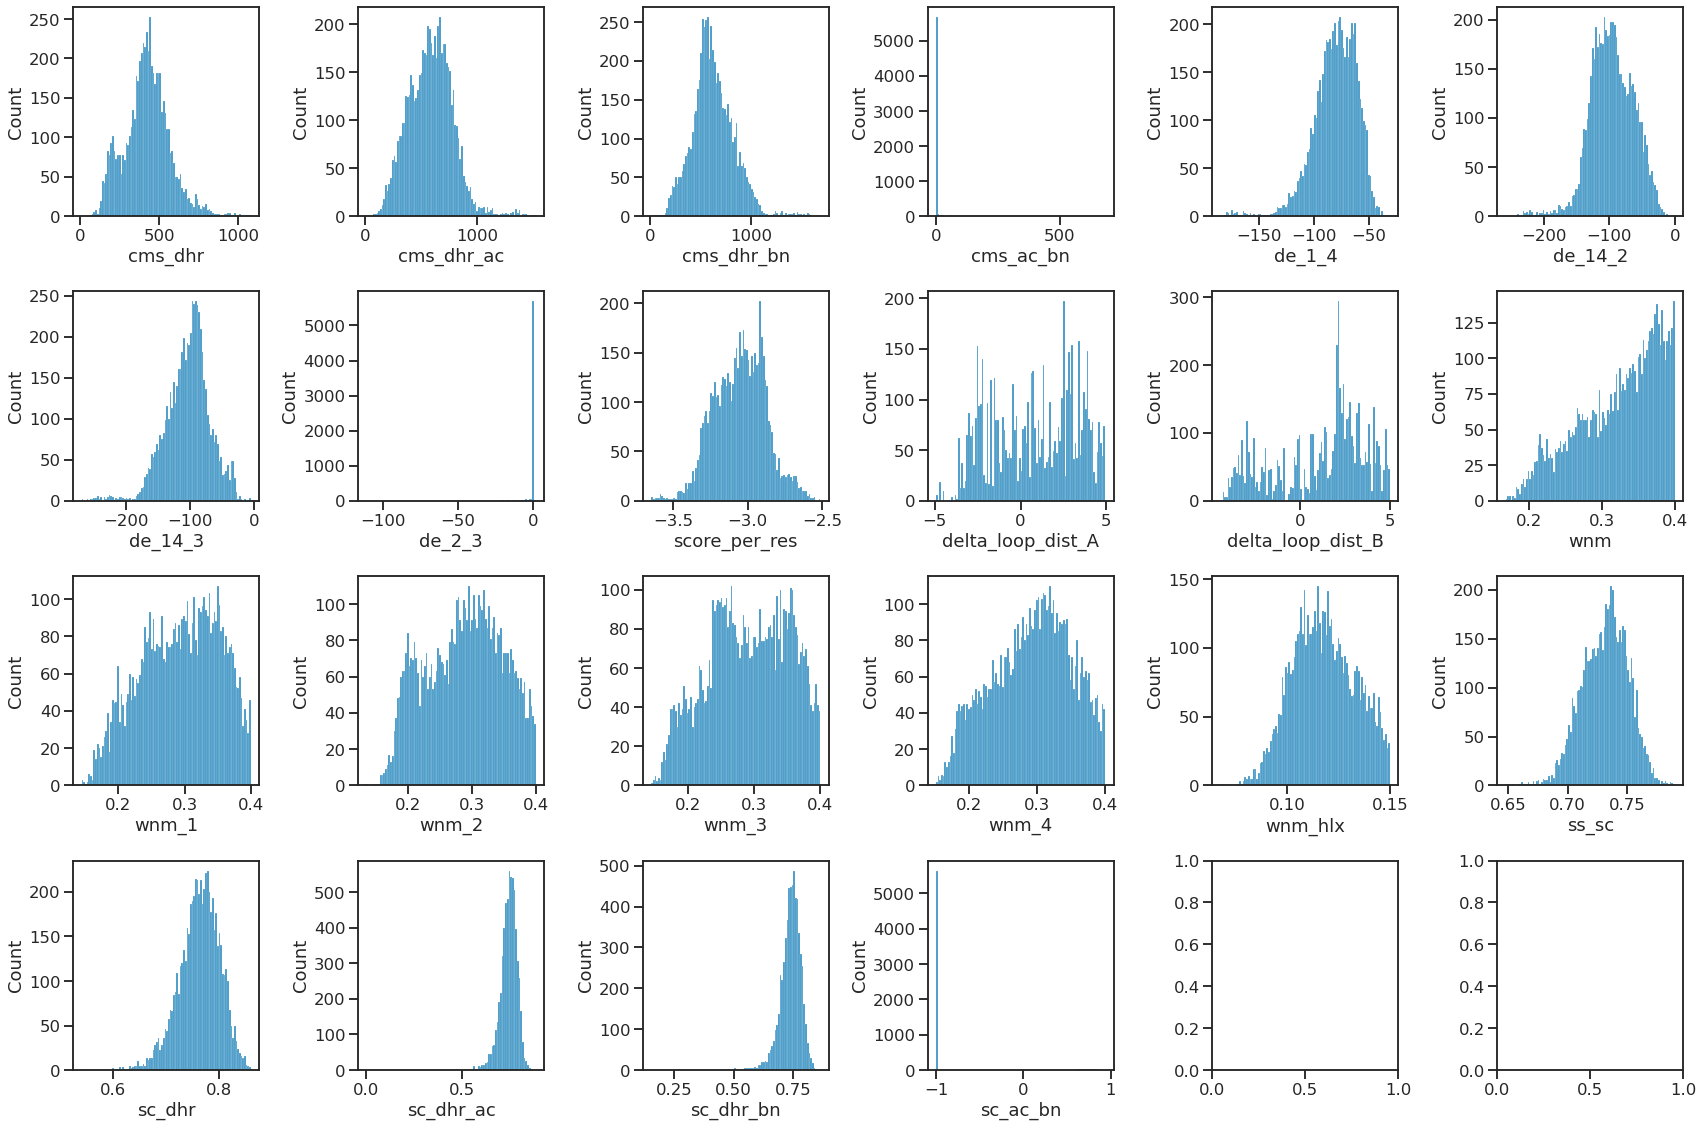

In [ ]:
histplot_df(filtered_df, cols=cols, bins=100)

In [ ]:
# Print some designs with a low cms_dhr to see what's going on
filtered_df[(filtered_df['cms_dhr'] < 250) & (filtered_df['cms_dhr'] > 100)].head()

,bb_clash,bb_clash_A,bb_clash_B,cms_ac_bn,cms_dhr,cms_dhr_ac,cms_dhr_bn,dhr_ac_int_count,dhr_bn_int_count,dhr_int_count,...,wnm_4,wnm_hlx,yhh_planarity,de_1_4,de_14_2,de_14_3,de_2_3,wnm,delta_loop_dist_A,delta_loop_dist_B
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_d1ad7b79dddf4566bed7b5cfc3893bcd.pdb.bz2,4802.529296875,37.104209899902344,613.51220703125,-1.0,152.555206,324.429718,314.094727,15.0,31.0,14.0,...,0.349887,0.115567,0.0015607019201311911,-54.029572,-48.922607,-51.904022,0.000000,0.373289,3.350112,-0.428913
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_26cfe49f56cd433b853590bf0036a35b.pdb.bz2,2832.929931640625,37.104209899902344,2794.31787109375,-1.0,128.971451,296.732544,126.221008,15.0,24.0,14.0,...,0.303265,0.104817,0.0015607019201311911,-58.131828,-53.166916,-20.153351,-0.000015,0.303265,3.350112,1.335908
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_376353fd43454de1a81ebaf97111c22d.pdb.bz2,3830.367919921875,83.42838287353516,33.57801818847656,-1.0,164.837845,380.278168,564.623840,25.0,26.0,9.0,...,0.372365,0.129447,0.0,-66.695847,-62.142914,-88.515152,0.000015,0.372365,-2.231566,-2.623765
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_07e549b98d9a448fae1201a0adb43c11.pdb.bz2,93.77511596679688,39.527923583984375,39.540775299072266,-1.0,172.258087,182.591873,515.746521,6.0,25.0,16.0,...,0.220597,0.116296,0.0,-59.769806,-33.011505,-89.368484,0.000015,0.244273,1.352373,4.078908
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_ff99bf7488e24615864ecb12ddb3e0b2.pdb.bz2,1970.9046630859375,217.2569122314453,41.76988220214844,0.0,201.844666,227.697098,549.590088,11.0,30.0,7.0,...,0.235904,0.093086,0.0,-54.693848,-34.643036,-92.858932,-0.000351,0.277871,-0.937124,2.493255


In [ ]:
parent_path = os.path.join(os.getcwd(), "00_inputs")
parent_scores = os.path.join(parent_path, "scaffold_scores.json")
parent_df = read_scorefile(parent_scores)
parent_df.set_index('name', inplace=True) # replaces the indexing by path to indexing by name
parent_df.head()

,cms_dhr,dslf_fa13,fa_atr,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,fa_intra_rep_xover4,...,score,score_1,score_12,score_2,score_per_res,ss_sc,total_score,wnm_1,wnm_2,wnm_hlx
name,,,,,,,,,,,,,,,,,,,,,
DHR79,465.784760,0.0,-1400.636238,20.246144,145.179909,274.889648,-579.788253,-75.762132,-46.974228,73.894970,...,-561.677002,-245.034546,-561.677002,-251.905350,-2.553077,0.698439,-561.676986,0.322625,0.316925,0.094490
DHR39,321.138519,0.0,-1021.834993,17.066784,143.013018,193.845212,-399.394071,-59.330212,-31.171610,63.490618,...,-385.315033,-170.901306,-385.315033,-169.123169,-2.335243,0.731973,-385.315035,0.377876,0.327590,0.085988
DHR82,521.558899,0.0,-1498.559091,21.318266,188.024945,262.872950,-583.674273,-79.204600,-40.859747,99.079365,...,-621.641541,-269.689850,-621.641541,-283.966553,-2.726498,0.744233,-621.641546,0.226993,0.237057,0.110452
DHR53,357.954865,0.0,-1060.006597,10.302994,129.002023,184.958473,-407.824125,-53.968461,-22.101187,61.719093,...,-457.311920,-204.453018,-457.311920,-195.076950,-2.722095,0.788842,-457.311918,0.384927,0.392240,0.087457
DHR54,401.634857,0.0,-1047.650966,13.488556,126.581043,188.660628,-426.607112,-60.735843,-40.887647,66.710380,...,-449.422302,-189.710556,-449.422302,-196.766571,-2.643661,0.702949,-449.422302,0.279068,0.318838,0.076508


8it [00:00, 13.38it/s]


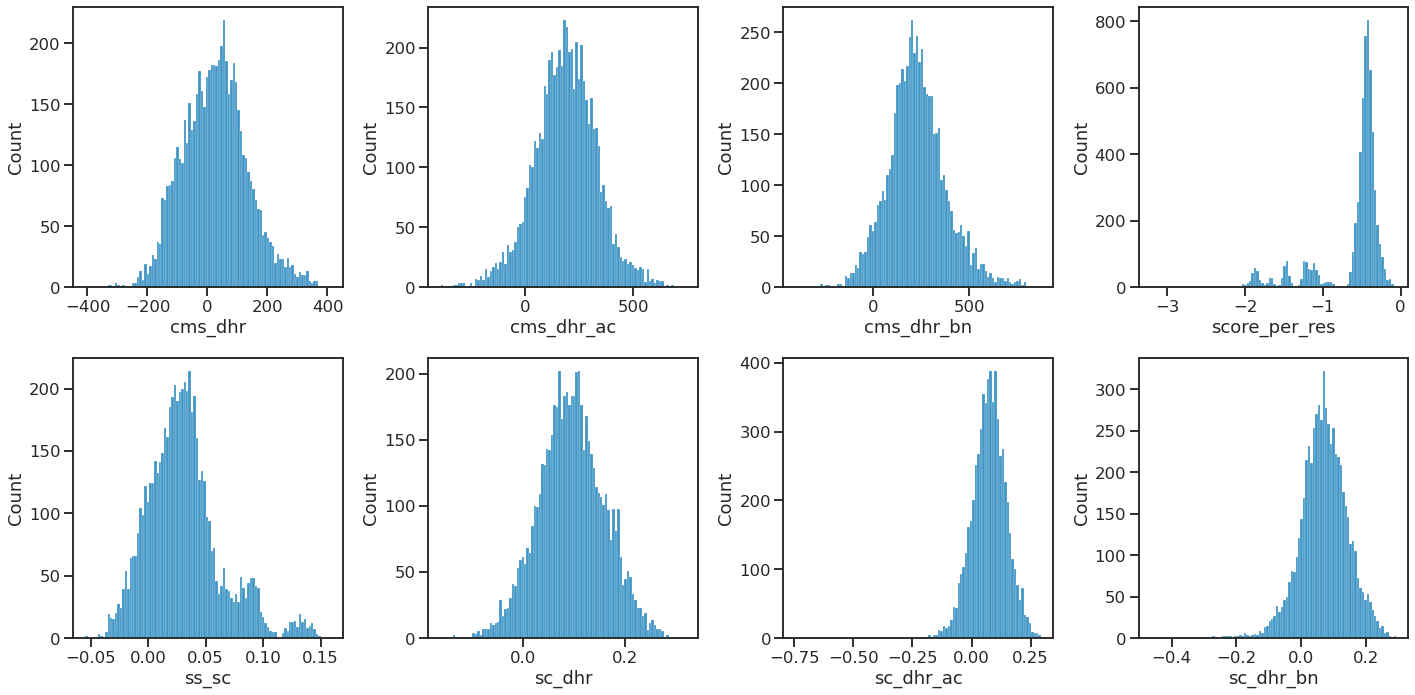

In [ ]:
# Plots distributions of delta scores between the parent and the children.
# Delta scores are calculated by design_value - parent_value.
# For scores which I'm trying to maximize, higher delta values are better.
# Conclusion: all score_per_res are better than the parents, and sc and cms usually increase, even for the side domains!
# Only cms_dhr decreases significantly from the parent.
# So, let's just filter based on whether designs are as good as or better than the parent (cutoffs at 0).

delta_pairs = [('cms_dhr', 'cms_dhr'),
               ('cms_dhr_ac', 'cms_dhr'),
               ('cms_dhr_bn', 'cms_dhr'),
               ('score_per_res', 'score_per_res'),
               ('ss_sc', 'ss_sc'),
               ('sc_dhr', 'sc_dhr'),
               ('sc_dhr_ac', 'sc_dhr'),
               ('sc_dhr_bn', 'sc_dhr')]

score_terms, parent_terms = tuple(map(list, zip(*delta_pairs)))
# gets the columns to filter on from the parent df, then duplicate rows by parent such that rows correspond to the parents of the rows of filtered df
parent_aligned_df = parent_df[parent_terms].loc[filtered_df['parent'], :]
parent_aligned_df.index = filtered_df.index
parent_aligned_df.columns = score_terms # fixes an issue with duplicate column names, and makes sure the output columns are correctly named
delta_df = filtered_df[score_terms] - parent_aligned_df

fig, axs = plt.subplots(2, 4, figsize=(20,10))

for col, ax in tqdm(zip(score_terms, axs.flatten())):
    sns.histplot(
        data=delta_df,
        x=col,
        ax=ax,
#         kde=True
#         hue='parent'
        bins=100
    )

plt.tight_layout()

In [ ]:
# Print some designs with a lower cms_dhr than the parent to see what's going on
delta_df[(delta_df['cms_dhr'] < -100) & (delta_df['cms_dhr'] > -130)].head()

# Looks like the presence of the side domains causes the parent dhr interface to shrink, with fewer boundary contacts.
# Apolar only cms could be a better metric here, though it will also be skewed since with the side domains,
# apolar residues could be placed on the boundary of the parent dhr interface.
# I think the solution is to use a lenient delta cutoff for the cms parent dhr interface, say 100, to allow a little bit of interface shrinkage.

,cms_dhr,cms_dhr_ac,cms_dhr_bn,score_per_res,ss_sc,sc_dhr,sc_dhr_ac,sc_dhr_bn
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_fc65c483fba64651a33a7a4280802a90.pdb.bz2,-128.324829,-15.476837,-11.097046,-0.464113,0.029996,0.149985,0.049623,0.176675
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_ae90ece13b2e479f8610fe7a5f4cede9.pdb.bz2,-103.946136,-103.946136,277.955505,-0.399581,0.011160,0.049645,0.035773,0.069932
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_f947caa9d5a24efdb7e096252cda6ac5.pdb.bz2,-109.094025,18.668335,-62.761383,-0.511388,0.045362,0.109118,0.179763,0.006487
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_9f424837609845e2bc16d256aed1b41b.pdb.bz2,-100.655853,-75.516815,174.447723,-0.298625,-0.008390,0.005022,-0.020437,0.047412
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_5fde7a1ebffb41648bcdf8ae8587e5c9.pdb.bz2,-110.717682,166.518494,166.639526,-0.368412,0.038626,0.064437,0.031934,0.063684


In [ ]:
# And some designs with a higher cms_dhr than the parent
delta_df[(delta_df['cms_dhr'] > 100) & (delta_df['cms_dhr'] < 200)].head()

,cms_dhr,cms_dhr_ac,cms_dhr_bn,score_per_res,ss_sc,sc_dhr,sc_dhr_ac,sc_dhr_bn
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_24a47b3ebec14870976d8fb3704d2114.pdb.bz2,117.482407,126.579025,361.987137,-0.617763,0.086550,0.229636,0.196603,0.216418
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_53ea34509c2a438a95746302758bf218.pdb.bz2,124.810333,161.839264,21.770935,-0.266335,0.001674,0.067127,-0.010735,-0.060917
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_c3d98ecea90941858ec4cb366f50cb1b.pdb.bz2,149.607880,201.059631,37.525909,-0.484502,0.042451,0.178258,0.110098,0.126626
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_324408d0458442279aa33fea01874f5f.pdb.bz2,192.689819,255.290955,-90.790558,-0.438677,0.032071,0.179362,0.103441,-0.052351
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_ccf71c810cda479e983e21d5c33554d6.pdb.bz2,139.716431,291.310547,159.460968,-1.081181,0.089481,0.202259,0.111226,0.146697


In [ ]:
# how do I determine these cutoffs? Look at distributions of delta cutoffs between the parent and the children

# here, "cutoff" means "if the design scores worse than the parent by x"
delta_cutoffs = [('cms_dhr', 'cms_dhr', 100, 1),
                 ('cms_dhr_ac', 'cms_dhr', 0, 1),
                 ('cms_dhr_bn', 'cms_dhr', 0, 1),
                 ('score_per_res', 'score_per_res', 0.2, 0),
                 ('ss_sc', 'ss_sc', 0, 1),
                 ('sc_dhr', 'sc_dhr', 0, 1),
                 ('sc_dhr_ac', 'sc_dhr', 0, 1),
                 ('sc_dhr_bn', 'sc_dhr', 0, 1)]

delta_filtered_df = filter_df_delta(filtered_df, parent_df, delta_cutoffs)

3894


In [ ]:
delta_filtered_df.head()

,bb_clash,bb_clash_A,bb_clash_B,cms_ac_bn,cms_dhr,cms_dhr_ac,cms_dhr_bn,dhr_ac_int_count,dhr_bn_int_count,dhr_int_count,...,wnm_4,wnm_hlx,yhh_planarity,de_1_4,de_14_2,de_14_3,de_2_3,wnm,delta_loop_dist_A,delta_loop_dist_B
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_c6b1cf65d1314fa4a7efe90793d83846.pdb.bz2,110.83558654785156,56.11193084716797,54.72365951538086,-1.000000,368.517517,514.184814,637.900879,26.0,35.0,19.0,...,0.365875,0.129802,0.0,-84.400955,-79.388901,-113.126328,0.000000,0.397061,3.469476,3.637717
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_6fbd5efe0f2d418eaaede06ebfcafd49.pdb.bz2,103.79744720458984,69.95219421386719,33.758880615234375,0.121686,322.327301,384.285004,297.629730,20.0,10.0,5.0,...,0.200958,0.108887,0.0,-61.021500,-56.934982,-45.760040,-0.066360,0.257751,2.432228,2.170160
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_24a47b3ebec14870976d8fb3704d2114.pdb.bz2,1557.638427734375,217.2569122314453,41.76988220214844,0.008344,323.293121,332.389740,567.797852,11.0,26.0,7.0,...,0.195241,0.094720,0.0,-54.572220,-54.002609,-86.780914,-0.161545,0.318429,-0.937124,2.551142
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_8603cd1f742e4099864ea98f3f085330.pdb.bz2,723.4216918945312,677.8851318359375,45.53658676147461,-1.000000,379.905334,460.021179,333.311035,30.0,8.0,16.0,...,0.246597,0.119761,0.0,-78.298401,-69.689209,-53.414337,0.000000,0.295750,-0.226501,1.960209
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_ff99bf7488e24615864ecb12ddb3e0b2.pdb.bz2,1970.9046630859375,217.2569122314453,41.76988220214844,0.000000,201.844666,227.697098,549.590088,11.0,30.0,7.0,...,0.235904,0.093086,0.0,-54.693848,-34.643036,-92.858932,-0.000351,0.277871,-0.937124,2.493255


22it [00:01, 12.13it/s]


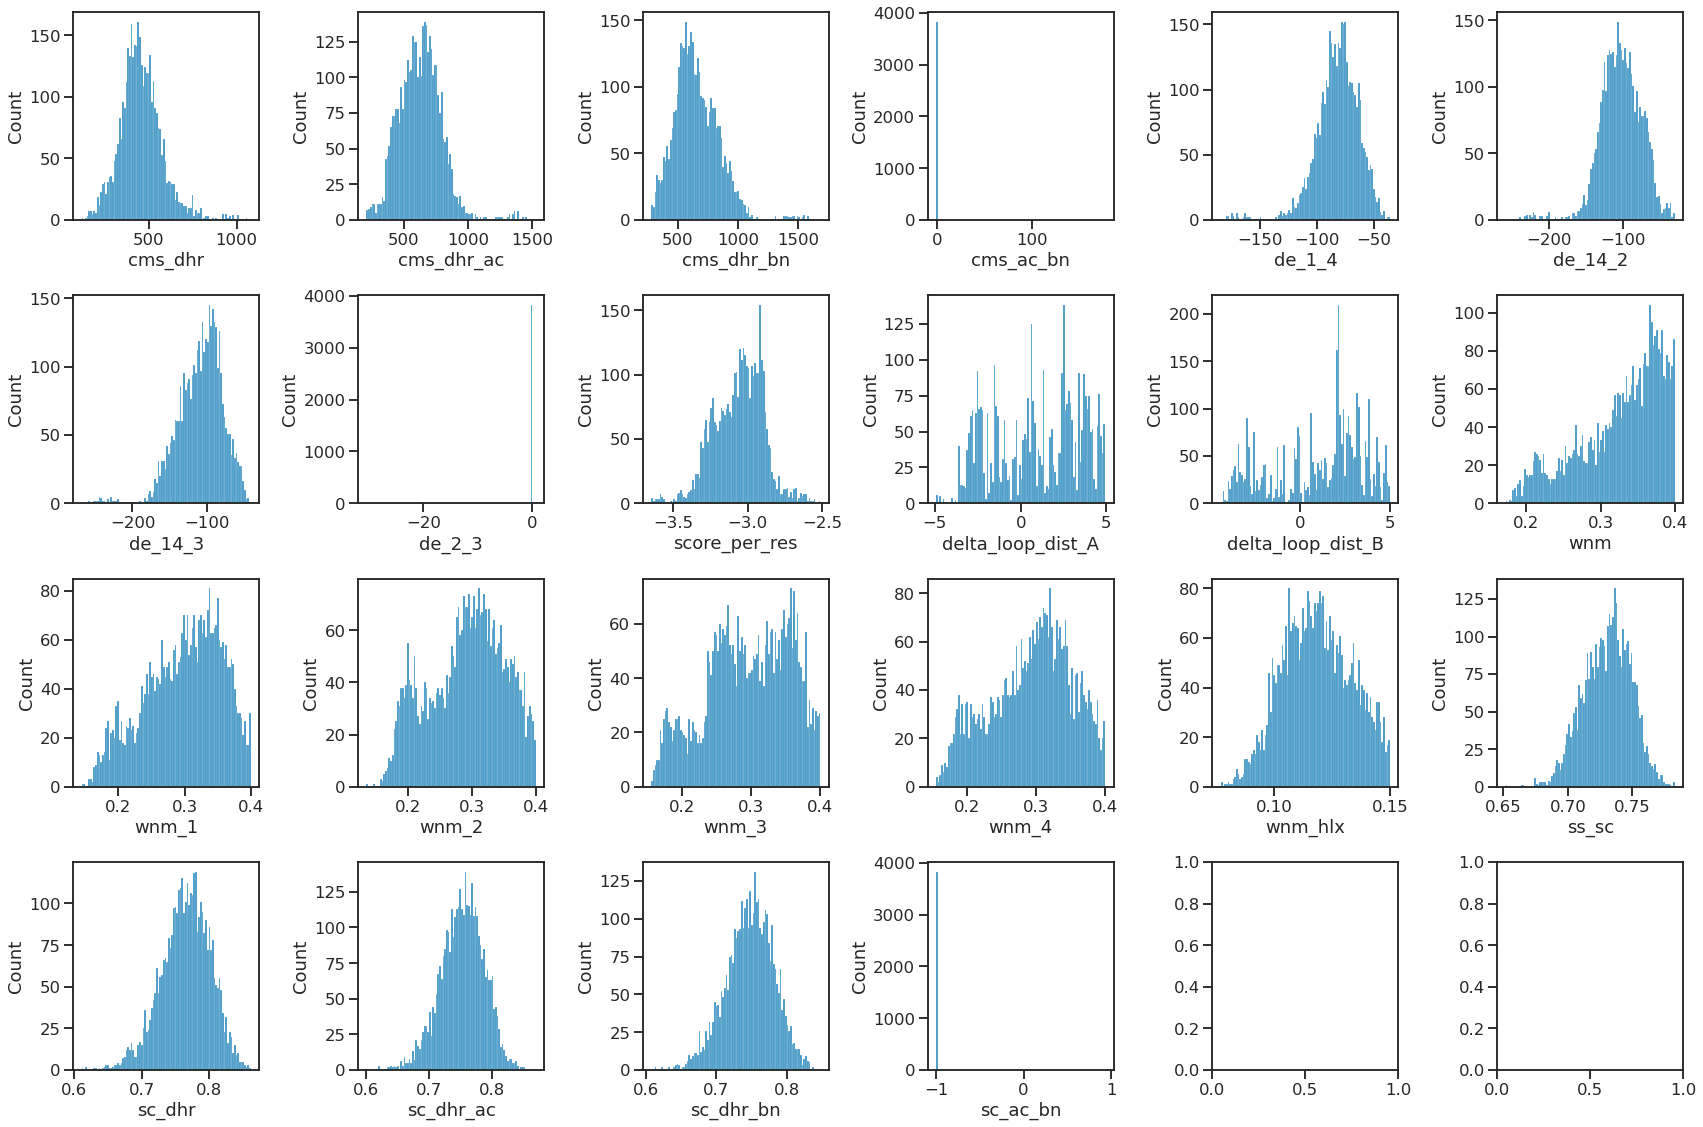

In [ ]:
histplot_df(delta_filtered_df, cols=cols, bins=50)

In [ ]:
# Print some of the second cms peak to see if they are THRs.
filtered_df[(filtered_df['cms_dhr'] > 900)].head()

,bb_clash,bb_clash_A,bb_clash_B,cms_ac_bn,cms_dhr,cms_dhr_ac,cms_dhr_bn,dhr_ac_int_count,dhr_bn_int_count,dhr_int_count,...,wnm_4,wnm_hlx,yhh_planarity,de_1_4,de_14_2,de_14_3,de_2_3,wnm,delta_loop_dist_A,delta_loop_dist_B
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_5611321baf9e45dd818718e3499dec18.pdb.bz2,1858.6153564453125,136.7066192626953,136.7066192626953,-1.0,931.114014,1324.395630,1379.208618,73.0,67.0,35.0,...,0.386356,0.118572,0.0,-170.655701,-220.189880,-222.227295,-0.000061,0.386356,1.836477,1.814585
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0001/02_design_filter_6982c26d040f44a7b085d1d7b05a5875.pdb.bz2,710.5448608398438,93.95706939697266,93.95706939697266,-1.0,919.657104,1308.585327,1495.255249,56.0,75.0,31.0,...,0.304422,0.119503,0.0,-178.142487,-211.855896,-242.634674,0.000031,0.355099,2.524035,1.423097
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0003/02_design_filter_05b8f80990ed401489a015828e1782ff.pdb.bz2,1161.6591796875,93.95706939697266,1067.7021484375,-1.0,957.721863,1382.148315,1471.747925,56.0,84.0,31.0,...,0.318141,0.114490,0.0,-173.107483,-219.464722,-238.964111,0.000000,0.334877,2.538482,0.990540
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0006/02_design_filter_b2c2025d3fe3471fba544b97e0845b61.pdb.bz2,4684.25537109375,415.87322998046875,4268.38232421875,-1.0,1039.502075,1210.291504,1311.909180,59.0,79.0,32.0,...,0.388562,0.122882,0.0,-169.250641,-201.625244,-199.020660,0.000031,0.388562,0.671074,1.295882
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0006/02_design_filter_33a3a3dbe07c40a3923ef91024fdd64d.pdb.bz2,4361.7734375,93.39134216308594,4268.38232421875,-1.0,1017.487244,1382.243408,1308.317993,61.0,79.0,32.0,...,0.364463,0.124909,0.0,-158.107056,-230.215424,-205.285248,0.000000,0.394730,-0.491061,1.295882


In [ ]:
# Nope, they're actually super long TH_DHRs.
# Did any THRs make it? Yes!
filtered_df[(filtered_df['pre_break_helix'] == '6.0')].head()

,bb_clash,bb_clash_A,bb_clash_B,cms_ac_bn,cms_dhr,cms_dhr_ac,cms_dhr_bn,dhr_ac_int_count,dhr_bn_int_count,dhr_int_count,...,wnm_4,wnm_hlx,yhh_planarity,de_1_4,de_14_2,de_14_3,de_2_3,wnm,delta_loop_dist_A,delta_loop_dist_B
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_cc0804dd5dab4653a606f6cef0fa8a8f.pdb.bz2,668.2564086914062,79.41667938232422,76.21759033203125,517.715881,307.120026,307.120026,536.304993,19.0,35.0,11.0,...,0.365453,0.116165,5.1897351971419425e-09,-88.877502,-50.799286,-86.879150,-88.783539,0.369996,-2.610209,3.678906
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_8d037d54967543d9b749056cdbc3ad5c.pdb.bz2,152.4293670654297,76.1240463256836,76.3053207397461,312.245422,357.603577,357.603577,811.348511,19.0,33.0,15.0,...,0.355521,0.143304,0.0,-125.721466,-56.937469,-138.479797,-43.052338,0.380786,1.667954,2.055666
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0000/02_design_filter_5611321baf9e45dd818718e3499dec18.pdb.bz2,1858.6153564453125,136.7066192626953,136.7066192626953,-1.000000,931.114014,1324.395630,1379.208618,73.0,67.0,35.0,...,0.386356,0.118572,0.0,-170.655701,-220.189880,-222.227295,-0.000061,0.386356,1.836477,1.814585
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0003/02_design_filter_ae123d6a369142ebb7f337cce05976bb.pdb.bz2,292.32464599609375,142.95269775390625,149.3719482421875,248.159149,421.329895,421.329895,790.366211,29.0,43.0,23.0,...,0.383369,0.121529,0.0,-123.729431,-66.783966,-130.769470,-34.588898,0.391315,2.311994,-0.613650
/mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/02_design_filter/decoys/0004/02_design_filter_6f45dca628604f61a89ef820da9a4829.pdb.bz2,343.88153076171875,194.50958251953125,149.3719482421875,305.212189,459.352905,459.352905,733.136169,28.0,43.0,23.0,...,0.354774,0.142260,0.0,-118.002136,-69.143097,-117.863068,-48.407532,0.395654,1.647608,-0.613650


In [ ]:
filtered_json_path = os.path.join(output_path, "filtered_designs.json")
delta_filtered_df.to_json(filtered_json_path)
filtered_list_path = os.path.join(output_path, "filtered_designs.list")
with open(filtered_list_path, 'w') as f:
    f.write('\n'.join(delta_filtered_df.index))

## Everything after this is for testing ##

In [20]:
from copy import deepcopy
test_df = deepcopy(filtered_df)

In [ ]:
# testing

sys.path.insert(0, "/home/broerman/projects/crispy_shifty")
from crispy_shifty.protocols.design import one_state_design_unlooped_dimer

pyrosetta.distributed.maybe_init(**{
    "options": "-corrections::beta_nov16 true",
    "extra_options":{
        "-out:level": "100",
        "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
        "-indexed_structure_store:fragment_store": "/home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",
        "-precompute_ig": "true"
}})

import pyrosetta.distributed.io as io
file = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/01_make_states/decoys/0000/CSD_01_make_states_4c315eabb34a449a886b9e9bd9b8227a.pdb.bz2'

for i in tqdm(range(1)):
    pposes = one_state_design_unlooped_dimer(None, **{'pdb_path': file})
    for ppose in pposes:
        designed_pose = io.to_pose(ppose)
        # designed_pose.dump_pdb(f"/home/broerman/projects/dimeric_hinges/dimeric_hinges_2/testing/02_design_filter/X23_3_20_3_ct7_fc.pdb")
        designed_pose.dump_pdb(f"/home/broerman/projects/dimeric_hinges/dimeric_hinges_2/testing/02_design_filter/X23_3_20_3_ct7_fc_fixbb2_{i:02d}.pdb")

  0%|          | 0/1 [00:00<?, ?it/s]

0.00 min: Generated interface selector
0.00 min: Generated interface design task factory
0.06 min: Generated score functions
0.06 min: Generated movemaps


/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


select design_sel, (chain A and resid 2,6,28,31,32,35,38,39,42,46,49,50,51,52,54,55,56,58,59,61,62,65,66,69,73,75,77,78,80,81,82,84,85,87,88,89,90,91,92,93,94,95) or (chain B and resid 103,106,107,109,110,113,114,117,122,123,125,126,127,129,130,132,133,134,136,137,140,182) or (chain C and resid 245,247,248,251,252,254,255,256,258,259,262,263,265,266,268,270,271,274,275,277,278,279,281,282,284,285) or (chain D and resid 289,290,291,292,293,294,295,296,297,299,300,301,303,304,306,307,308,310,315,318,319,322,323,325,326,327,329,330,332,333,334,342,346,349,350,353,356,360)
0.21 min: Generating structure profile...complete.
0.21 min: Starting 1 round of fixed backbone design...complete.
36.09 min: Starting 2 rounds of flexible backbone design...complete.
36.09 min: Clearing constraints...complete.
36.09 min: Scoring contact molecular surface and shape complementarity...core.scoring.sc.ShapeComplementarityCalculator: {0} [ ERROR ] Failed: No molecular dots generated!
protocols.simple_filters

In [ ]:
# testing

sys.path.insert(0, "/home/broerman/projects/crispy_shifty")
from crispy_shifty.protocols.design import one_state_design_unlooped_dimer

pyrosetta.distributed.maybe_init(**{
    "options": "-corrections::beta_nov16 true",
    "extra_options":{
        "-out:level": "100",
        "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
        "-indexed_structure_store:fragment_store": "/home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",
        "-precompute_ig": "true"
}})

import pyrosetta.distributed.io as io
file = '/home/broerman/projects/dimeric_hinges/dimeric_hinges_2/testing/01_make_states/DHR21/DHR21_A_-1_0_DHR21_B_1_1.pdb'

for i in tqdm(range(1)):
    pposes = one_state_design_unlooped_dimer(None, **{'pdb_path': file})
    for ppose in pposes:
        designed_pose = io.to_pose(ppose)
        # designed_pose.dump_pdb(f"/home/broerman/projects/dimeric_hinges/dimeric_hinges_2/testing/02_design_filter/X23_3_20_3_ct7_fc.pdb")
        designed_pose.dump_pdb(f"/home/broerman/projects/dimeric_hinges/dimeric_hinges_2/testing/02_design_filter/DHR21_{i:02d}.pdb")

  0%|          | 0/1 [00:00<?, ?it/s]

0.00 min: Generated interface selector
0.00 min: Generated interface design task factory
0.06 min: Generated score functions
0.06 min: Generated movemaps


/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


select design_sel, (chain A and resid 2,5,9,25,28,38,39,40,42,43,44,46,47,50,51,54,55,59,60,62,63,64,66,67,69,70,71,73) or (chain B and resid 74,76,77,78,80,81,82,84,85,87,88,96,100,103,104,107,108) or (chain C and resid 151,187,188,189,190,192,193,195,196,197,199,200,203,204,208,209,211,212,213,215,216,217,218,219,220,221,222) or (chain D and resid 224,226,227,229,230,231,233,234,235,236,237,238,240,245,246,247,249,250,252,253,254,256,257,259,268,269,272,275,276)
0.22 min: Generating structure profile...complete.
5.91 min: Starting 1 round of fixed backbone design...complete.
32.86 min: Starting 2 rounds of flexible backbone design...complete.
88.69 min: Clearing constraints...complete.
88.69 min: Scoring contact molecular surface and shape complementarity...core.scoring.sc.ShapeComplementarityCalculator: {0} [ ERROR ] Failed: No molecular dots generated!
protocols.simple_filters.ShapeComplementarityFilter: {0} [ ERROR ] Issue running shape complementarity calculator - returning -1 in